In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline

import re


In [2]:
# 读取数据
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

In [3]:
# 查看数据类型和缺失情况
train_data.info(),test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

(None, None)

In [4]:
# 部分数据详情
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 提取Name中称呼，如Mr，Mrs，Miss等
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [5]:
#增加一个Title特征，对称呼分类
train_data['Title']=train_data['Name'].apply(get_title)#名字只保留称呼

#分为Rare尊贵称呼，以及女士、小姐、男士
train_data['Title'] = train_data['Title'].replace(['Master','Don', 'Rev','Dr', 'Major','Lady',
                                                 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'], 'Rare')

#分出小姐和夫人
train_data['Title'] = train_data['Title'].replace('Mlle', 'Miss')
train_data['Title'] = train_data['Title'].replace('Ms', 'Miss')
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')

In [7]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')

<b>考察各列数据</b>

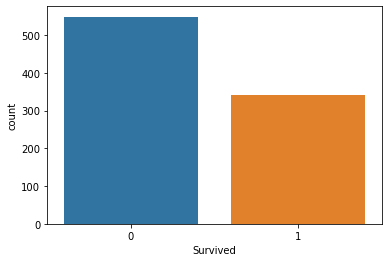

In [103]:
# 总体存活情况
sns.countplot(x='Survived',data=train_data)

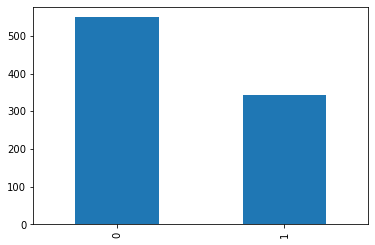

In [8]:
# 这样也行
train_data.Survived.value_counts().plot(kind='bar')

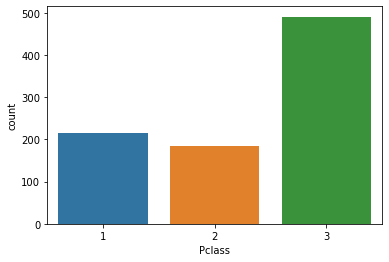

In [107]:
# 等级情况
sns.countplot(x='Pclass',data=train_data)
# train_data.Pclass.value_counts().plot(kind='bar')

In [65]:
# 不同等级的存活情况
pd.pivot_table(train_data,columns='Survived',index='Pclass',values='PassengerId',aggfunc='count')

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


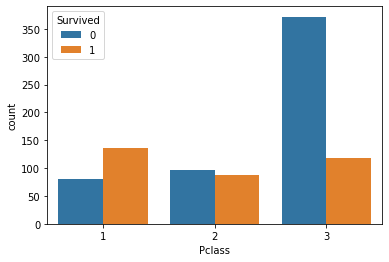

In [110]:
# 不同等级可视化
sns.countplot(x='Pclass',hue='Survived',data=train_data)
# 第二种方法，比较笨
# a=train_data.groupby(by=['Pclass','Survived']).count().reset_index(1)# reset_index展开第二个index
# sns.barplot(x=a.index,y='PassengerId',hue='Survived',data=a)# x不能用Pclass

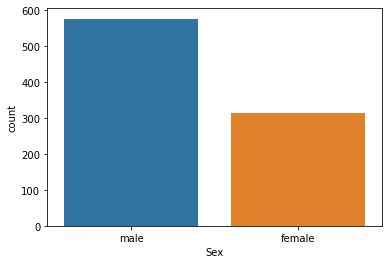

In [108]:
# 男女分布
sns.countplot(x='Sex',data=train_data)
# train_data.Sex.value_counts().plot(kind='bar')

In [53]:
# 男女存活情况 透视表
pd.pivot_table(train_data,index='Sex',columns='Survived',values='PassengerId',aggfunc='count')

Survived,0,1
Sex,,
female,81,233
male,468,109


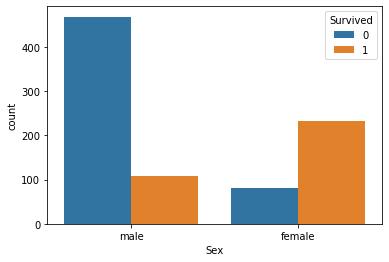

In [109]:
# 可视化
sns.countplot(x='Sex',hue='Survived',data=train_data)
# 第二种方法
# a=train_data.groupby(by=['Sex','Survived']).count().reset_index(1)
# sns.barplot(x=a.index,y='PassengerId',hue='Survived',data=a)

In [15]:
# 年龄有缺失，我们通过随机森林建模填补

from sklearn.ensemble import RandomForestRegressor
def set_missing_ages(df):
    
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].values
    unknown_age = age_df[age_df.Age.isnull()].values

    # y即目标年龄
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中训练
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1:])
    
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df, rfr

In [16]:
set_missing_ages(train_data)

(     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex       Age  \
 0                              Braund, Mr. Owen Harris    male  22.00000   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.00000   
 2                               Heikkinen, Miss. Laina  female  26.00000   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.00000   
 4                             Allen, Mr. William Henry    male  35.00000   
 ..                                                 ...     ...     

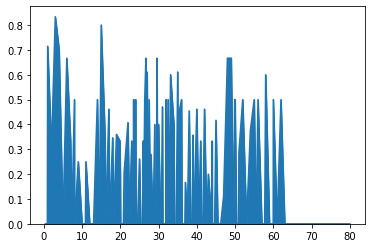

In [51]:
# 不同年龄的存活率
sur=train_data.Age[train_data.Survived==1].value_counts()
die=train_data.Age[train_data.Survived==0].value_counts()
per=sur/(sur+die)
# help(per.plot)
per.plot(kind='area')

In [116]:
# 年龄分块
train_data['Age_bin']=pd.cut(train_data['Age'],bins=[0,10,45,90],labels=['children','mid','elder'])

In [18]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Age_bin'],
      dtype='object')

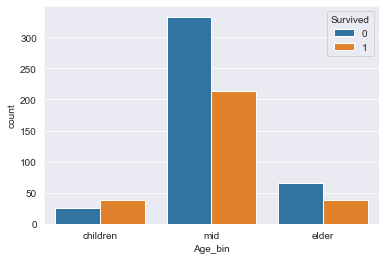

In [117]:
# 年龄分布，只有儿童存活大于死亡
sns.countplot(x='Age_bin',hue='Survived',data=train_data)


In [119]:
# 新特征：家庭成员大小，同一家庭的应该会一样，统计有偏差
train_data['FamilySize']=train_data['SibSp']+train_data['Parch']+1

In [120]:
# 家庭大小分区
train_data['Family_bin']=pd.cut(train_data.FamilySize,bins=[0,1,4,7,12],labels=['little','small','medium','large'])

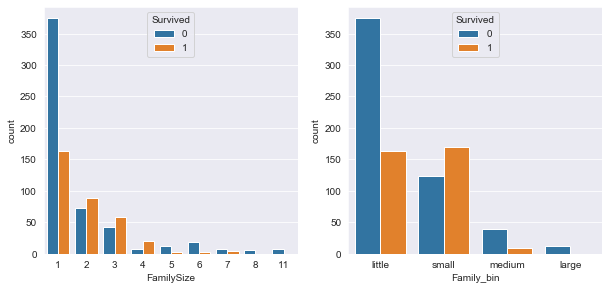

In [122]:
# 看看不同家庭大小对存活率的影响
fig=plt.figure(figsize=(10,10))
# 只有一个人的时候，容易死亡，但是家庭人员多，其中之一死亡可能比一个人的时候死更容易
# 可以看出，家庭成员为2,3,4时存活率最高
ax1=fig.add_subplot(2,2,1)
sns.countplot(x='FamilySize',hue='Survived',data=train_data)
ax2=fig.add_subplot(2,2,2)
sns.countplot(x='Family_bin',hue='Survived',data=train_data)

In [25]:
# Ticket无明显特征，暂不考虑
train_data.Ticket.value_counts()

CA. 2343         7
347082           7
1601             7
3101295          6
CA 2144          6
                ..
S.O./P.P. 751    1
PC 17597         1
323592           1
2662             1
364850           1
Name: Ticket, Length: 681, dtype: int64

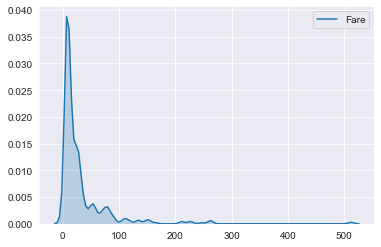

In [123]:
# 费用
sns.kdeplot(train_data.Fare,shade=True)
# train_data.Fare.value_counts(sort=False).sort_index().plot()

In [126]:
train_data.Fare.fillna(0,inplace=True)# 少量缺失的以0填补

In [127]:
# 费用分区
train_data['Fare_bin']=pd.cut(train_data.Fare,bins=[-1,100,300,600],labels=['little','mid','big'])

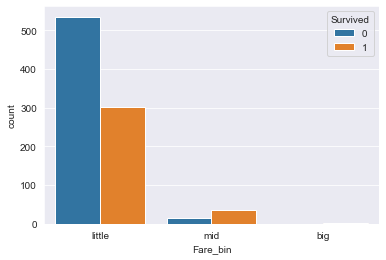

In [128]:
# 不同费用的存活率，肯定是费用高，等级舱高，存活率大
sns.countplot(x='Fare_bin',hue='Survived',data=train_data)

In [133]:
# big分区只有3个，可视化显示看不出，可以看到都存活了
train_data[train_data['Fare_bin']=='big']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,FamilySize,Family_bin,Fare_bin
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,Miss,mid,1,little,big
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Mr,mid,2,small,big
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,Mr,mid,1,little,big


In [42]:
train_data.Cabin.describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [134]:
# Cabin缺失较多，根据Cabin存在与否分类
# type(train_data['Cabin'][0])
def replace_Cabin(name):
    if type(name)==str:
        return "Yes"
    else:
        return "No"
train_data['Cabin']=train_data['Cabin'].apply(replace_Cabin)


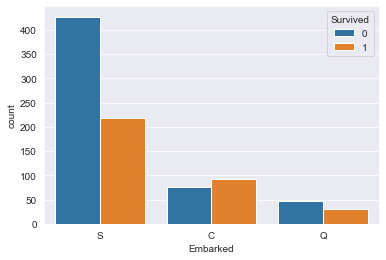

In [137]:
# 港口，可见存活率与港口也有关系
sns.countplot(x='Embarked',hue='Survived',data=train_data)
# train_data.Embarked.value_counts().plot(kind='bar')

In [136]:
# 最后，处理缺失，以最常见的填充
train_data['Embarked'].fillna('S', inplace = True)

In [69]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    object  
 11  Embarked     891 non-null    object  
 12  Title        891 non-null    object  
 13  Age_bin      891 non-null    category
 14  FamilySize   891 non-null    int64   
 15  Family_bin   891 non-null    category
 16  Fare_bin     891 non-null    category
dtypes: category(3), float64(2), int64(6), object(6)
memory usage: 100.6+ KB


In [85]:
cols=['Pclass','Sex','Cabin','Embarked','Title','Age_bin','Family_bin','Fare_bin']
# 对类别型数据的每个类别单独作为一列
X=pd.get_dummies(train_data,columns=cols)
# 用于展示相关性
X_show=X.drop(['PassengerId', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare','FamilySize','Name'],axis=1)
# 用于训练
X=X.drop(['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare','FamilySize','Name'],axis=1)

In [78]:
Y=train_data['Survived']

In [79]:
X.describe()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,...,Age_bin_children,Age_bin_mid,Age_bin_elder,Family_bin_little,Family_bin_small,Family_bin_medium,Family_bin_large,Fare_bin_little,Fare_bin_mid,Fare_bin_big
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.242424,0.206510,0.551066,0.352413,0.647587,0.771044,0.228956,0.188552,0.086420,0.725028,...,0.077441,0.797980,0.124579,0.602694,0.327722,0.054994,0.014590,0.940516,0.056117,0.003367
std,0.428790,0.405028,0.497665,0.477990,0.477990,0.420397,0.420397,0.391372,0.281141,0.446751,...,0.267440,0.401733,0.330427,0.489615,0.469646,0.228097,0.119973,0.236661,0.230276,0.057961
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


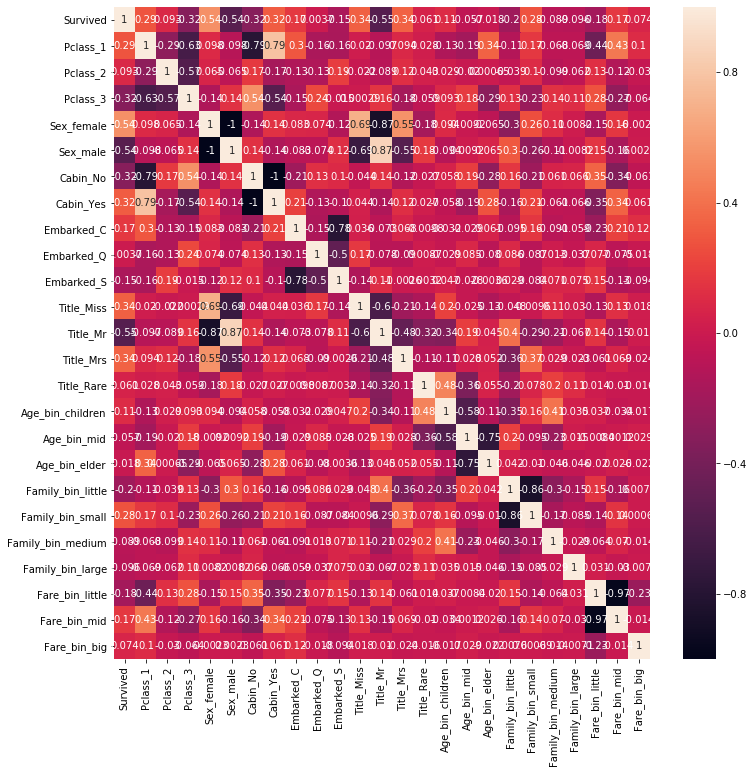

In [86]:
# 相关系数矩阵的热图，可以得出若干结论：
# 有舱且等级越高，女性，儿童，家庭成员数目较小，票价越高，则存活率越高
plt.figure(figsize=(12,12))
sns.heatmap(X_show.corr(),annot=True)

<b>准备建模</b>

In [87]:
from sklearn.model_selection import train_test_split #for split the data
# 准备若干分类器
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV#模型微调

In [88]:
# 分出验证集
x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.2,random_state=13)

In [97]:
# 构建4个网格搜索，探索给定参数中的最佳组合
xgb=XGBClassifier()
n_est=range(100,1000,100)
lr=[0.001,0.01,0.1,0.2,0.3]
gamma=[1,0.1,0.01]
params={'n_estimators':n_est,'learning_rate':lr,'gamma':gamma}
m1=GridSearchCV(xgb,param_grid=params,cv=3,scoring="accuracy", n_jobs= -1)

In [93]:
rfc=RandomForestClassifier()
params={'n_estimators':range(100,501,100),'min_samples_split':range(5,21,5),'min_samples_leaf':range(2,10,2)}
m2=GridSearchCV(rfc,param_grid=params,cv=3,scoring='accuracy',n_jobs=-1)

In [94]:
dtc=DecisionTreeClassifier()
params={'min_samples_split':range(5,21,5),'min_samples_leaf':range(2,10,2)}
m3=GridSearchCV(dtc,param_grid=params,cv=3,scoring='accuracy',n_jobs=-1)

In [95]:
svc=SVC()
params={'kernel':['rbf','sigmoid','poly'],'gamma':[1,0.1,0.01]}
m4=GridSearchCV(svc,param_grid=params,cv=3,scoring='accuracy',n_jobs=-1)

In [98]:
# 开始探索
m1.fit(x_train,y_train)
m2.fit(x_train,y_train)
m3.fit(x_train,y_train)
m4.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [99]:
# 最佳参数组合
m1.best_params_,m2.best_params_,m3.best_params_,m4.best_params_

({'gamma': 0.1, 'learning_rate': 0.01, 'n_estimators': 700},
 {'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100},
 {'min_samples_leaf': 2, 'min_samples_split': 5},
 {'gamma': 0.1, 'kernel': 'poly'})

In [ ]:
m1.best_estimator_#最佳模型

<b>看看在验证集上的精度</b>

In [100]:
from sklearn.metrics import accuracy_score 

In [101]:
model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bynode=1,
                    colsample_bytree=1, gamma=0.1,learning_rate=0.01, max_delta_step=0, max_depth=4,
                    min_child_weight=3, missing=None, n_estimators=700, n_jobs=1,nthread=None, 
                    objective='binary:logistic', random_state=0,reg_alpha=0, reg_lambda=1, 
                    scale_pos_weight=1, seed=None,silent=None, subsample=1, verbosity=1)
model.fit(x_train,y_train)
pre_y=model.predict(x_val)
accuracy_score(pre_y,y_val)

0.8435754189944135

In [103]:
# 这个最好，但还没以前的好
model2=RandomForestClassifier(min_samples_leaf=4, min_samples_split=10, n_estimators=100)
model2.fit(x_train,y_train)
pre_y=model2.predict(x_val)
accuracy_score(pre_y,y_val)

0.8603351955307262

In [104]:
model3=DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=5)
model3.fit(x_train,y_train)
pre_y=model3.predict(x_val)
accuracy_score(pre_y,y_val)

0.8324022346368715

In [105]:
model4=SVC(kernel='poly',gamma=0.1)
model4.fit(x_train,y_train)
pre_y=model4.predict(x_val)
accuracy_score(pre_y,y_val)

0.8491620111731844

In [315]:
# 不使用Fare特征时，最佳验证结果优化了一点
# 提交测试结果得分为0.79多
model5=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bynode=1,
                    colsample_bytree=1, gamma=0.01,learning_rate=0.05, max_delta_step=0, max_depth=4,
                    min_child_weight=3, missing=None, n_estimators=700, n_jobs=1,nthread=None, 
                    objective='binary:logistic', random_state=0,reg_alpha=0, reg_lambda=1, 
                    scale_pos_weight=1, seed=None,silent=None, subsample=1, verbosity=1)
model5.fit(x_train,y_train)
pre_y=model5.predict(x_val)
accuracy_score(pre_y,y_val)

0.8659217877094972

<b>以上模型最后训练时应该使用全部训练数据，包括验证集</b>

<b>预测</b>

In [107]:
# 测试集对数据执行与训练集相同的处理

test_data['Title']=test_data['Name'].apply(get_title)
# 测试数据多了个Dona
test_data['Title'] = test_data['Title'].replace(['Master','Don','Dona','Rev','Dr', 'Major','Lady',
                                                 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'], 'Rare')

#分出小姐和夫人
test_data['Title'] = test_data['Title'].replace('Mlle', 'Miss')
test_data['Title'] = test_data['Title'].replace('Ms', 'Miss')
test_data['Title'] = test_data['Title'].replace('Mme', 'Mrs')

In [116]:
set_missing_ages(test_data)
test_data['FamilySize']=test_data['SibSp']+test_data['Parch']+1
test_data['Age_bin']=pd.cut(test_data['Age'],bins=[0,10,45,90],labels=['children','mid','elder'])
test_data['Family_bin']=pd.cut(test_data.FamilySize,bins=[0,1,4,7,12],labels=['little','small','medium','large'])
test_data.Fare.fillna(0,inplace=True)
test_data['Fare_bin']=pd.cut(test_data.Fare,bins=[-1,100,300,600],labels=['little','mid','big'])
test_data['Cabin']=test_data['Cabin'].apply(replace_Cabin)
cols=['Pclass','Sex','Cabin','Embarked','Title','Age_bin','Family_bin','Fare_bin']

In [117]:
test_X=pd.get_dummies(test_data,columns=cols)

In [118]:
test_x=test_X.drop(['PassengerId', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare','Name',
       'FamilySize'],axis=1)

In [136]:
# 因为Cabin没有缺失，所以要自己补上一列
test_x['Cabin_No']=0
# 并重新排好列的顺序
test_x=test_x.reindex(columns=['Pclass_1','Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_No', 'Cabin_Yes', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Age_bin_children', 'Age_bin_mid', 'Age_bin_elder', 'Family_bin_little', 'Family_bin_small', 'Family_bin_medium', 'Family_bin_large', 'Fare_bin_little', 'Fare_bin_mid', 'Fare_bin_big'])

In [144]:
# 将多个模型预测结果分别输出到文件中
i=11
for m in [model,model2,model3,model4]:
    test_y=m.predict(test_x)
    result=pd.DataFrame({'PassengerId':test_data['PassengerId'].values,'Survived':test_y.astype(np.int32)})
    result.to_csv('result'+str(i)+'.csv',index=False)
    i=i+1
    

<b>过拟合分析</b>

In [140]:
from sklearn.model_selection import learning_curve

In [145]:

train_sizes, train_scores, test_scores = learning_curve(
        model, X, Y, cv=3, n_jobs=-1, train_sizes=np.linspace(.05, 1., 20),scoring='accuracy')

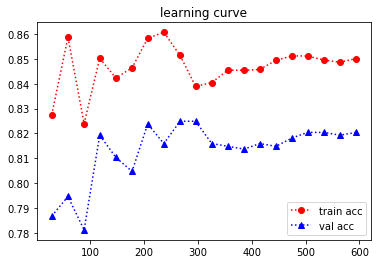

In [146]:
# train_sizes在300以上表现为过拟合
t_score=np.mean(train_scores,axis=1)
v_score=np.mean(test_scores,axis=1)
plt.plot(train_sizes,t_score,'ro:',label='train acc')
plt.plot(train_sizes,v_score,'b^:',label='val acc')
plt.legend()
plt.title('learning curve')
plt.show()

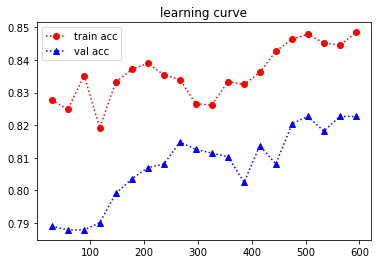

In [147]:
# 随机森林模型未出现过拟合
train_sizes, train_scores, test_scores = learning_curve(
        model2, X, Y, cv=3, n_jobs=-1, train_sizes=np.linspace(.05, 1., 20),scoring='accuracy')
t_score=np.mean(train_scores,axis=1)
v_score=np.mean(test_scores,axis=1)
plt.plot(train_sizes,t_score,'ro:',label='train acc')
plt.plot(train_sizes,v_score,'b^:',label='val acc')
plt.legend()
plt.title('learning curve')
plt.show()

<b>单变量调优</b>

In [148]:
from sklearn.model_selection import validation_curve

In [150]:

# n_estimators:700
# xs=range(100,1000,100)
# learning_rate:0.05
# lr=[0.03,0.04,0.05,0.06,0.07]
# gamma:no effect
# gamma=[1,0.1,0.01]
# depth:4
# depth=range(3,8)
# booster:gbtree or dart
# booster=['gbtree','gblinear','dart']
# min_child_weight:3
min_child_weight=range(1,10)
#可以对单个变量进行调节，单个调节不如综合调节，但是可以对各个变量确定一下调节范围
train_score,val_score=validation_curve(XGBClassifier(),X,Y,param_name='min_child_weight',param_range=min_child_weight,scoring="accuracy",cv=10,n_jobs=-1)

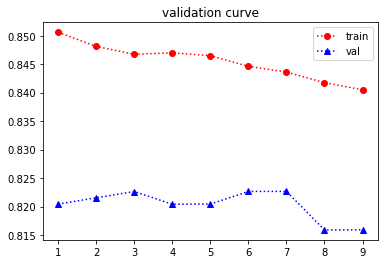

In [151]:
trs=np.mean(train_score,axis=1)
vas=np.mean(val_score,axis=1)
plt.plot(min_child_weight,trs,'ro:',label='train')
plt.plot(min_child_weight,vas,'b^:',label='val')
plt.title('validation curve')
plt.legend()
plt.show()

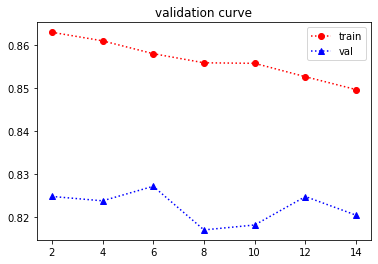

In [153]:
# 随机森林分类器，min_samples_split：6
train_score,val_score=validation_curve(RandomForestClassifier(),X,Y,param_name='min_samples_split',param_range=range(2,16,2),scoring="accuracy",cv=10,n_jobs=-1)
trs=np.mean(train_score,axis=1)
vas=np.mean(val_score,axis=1)
plt.plot(range(2,16,2),trs,'ro:',label='train')
plt.plot(range(2,16,2),vas,'b^:',label='val')
plt.title('validation curve')
plt.legend()
plt.show()